# Dependencies

In [1]:
import funct
import importlib
import numpy as np
import pandas as pd
import os
import IPython
import netCDF4 as nc
import  xarray as xr
from datetime import datetime, timedelta

# Set up global variables

In [2]:
# Recognize the current operating system
if os.name == "nt":  # Windows
    delimiter = "\\"
else:  # Unix or Linux
    delimiter = "/"
    

# Read historical CCS data

Issues to solve:
- Incomplete data of June, 2021
- Data up to 2024/3/8, need to dynamically download data after this date

In [3]:
freq = 3

rela_path_base = f"Data{delimiter}Persian_CCS_201901_202403{delimiter}CCS_esmJSON_2024-03-08075032am_"


# Get the current working directory
current_dir = delimiter.join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split(delimiter)[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Might need to modify the prefix of the parent_dir if necessary depending on different OS and device
os.chdir("/users/"+parent_dir)
# Now, your current working directory is the parent folder.

df_list = []
first_iter = True
for month in funct.iterate_months(2019, 1, 2024, 3):
    rela_path = rela_path_base + month + ".nc"
    df = funct.create_time_series_dataframe(freq, rela_path)
    if first_iter:
        df = df.replace(-99,np.nan)
        cols_after_drop = df.dropna(axis=1, how='any').columns
        first_iter = False
    df_dropped = df[[col for col in cols_after_drop]]
    df_list.append(df_dropped)
df_ccs = pd.concat(df_list)
# orginal shape of the Esmeraldas basin is of size 53*52
# New flat array of 1098 pixels, showing only the net pixels of this basin area 

# Read data from Esmeraldas station
## Update ESM sensor data from ftp
Check the local path and download all the observations from ftp if it's not in the local folder yet

In [22]:
from ftplib import FTP
import os
from datetime import datetime, timedelta

local_base_folder = f"Data{delimiter}Esm_Station"
# local_base_folder = "Data/Esm_Station"


# FTP server details
ftp_server = "186.42.174.238"
username = "sistec"
password = "ftpst2012"

# Connect to the FTP server
ftp = FTP(ftp_server)
ftp.login(username, password)

# Change to the desired directory (optional)
ftp.cwd(f"TEST_ESTACIONES_AUTOMATICAS{delimiter}H5033{delimiter}D1{delimiter}F10")
# ftp.cwd("TEST_ESTACIONES_AUTOMATICAS/H5033/D1/F10")

# Find the latest date of existing files in the local folder
latest_local_date = None
for root, dirs, files in os.walk(local_base_folder):
    for file in files:
        if file.endswith(".csv"):
            file_date = datetime.strptime(file[:8], "%Y%m%d").date()
            if latest_local_date is None or file_date > latest_local_date:
                latest_local_date = file_date

# List all the files and folders in the current directory
files_and_folders = ftp.nlst()

# Filter out the folders starting with "yd"
yd_folders = [folder for folder in files_and_folders if folder.startswith("yd")]

for yd_folder in yd_folders:
    # Extract the year from the "yd" folder name
    yd_year = int(yd_folder[2:])
    
    # Check if the "yd" folder contains CSV files later than the latest local date
    if latest_local_date is None or yd_year >= latest_local_date.year:
        # Change to the "yd" folder
        ftp.cwd(yd_folder)
        files_and_folders = ftp.nlst()
        
        # Filter out the folders starting with "md"
        md_folders = [folder for folder in files_and_folders if folder.startswith("md")]
        
        for md_folder in md_folders:
            # Extract the year and month from the "md" folder name
            md_year = int(md_folder[2:6])
            md_month = int(md_folder[6:])
            
            # Check if the "md" folder contains CSV files later than the latest local date
            if latest_local_date is None or (md_year, md_month) >= (latest_local_date.year, latest_local_date.month):
                # Change to the "md" folder
                ftp.cwd(md_folder)
                
                # List all the CSV files in the current folder
                csv_files = [file for file in ftp.nlst() if file.endswith(".csv")]
                
                for csv_file in csv_files:
                    # Extract the date from the CSV file name
                    file_date = datetime.strptime(csv_file[:8], "%Y%m%d").date()
                    
                    # Set the specific time to be 23:55 of the file date
                    specific_datetime = datetime.combine(file_date, datetime.strptime("23:55", "%H:%M").time())
                    
                    # Add one day to the specific time
                    specific_datetime += timedelta(days=1)
                    
                    # Get the last modified time of the CSV file
                    last_modified_time = ftp.voidcmd(f"MDTM {csv_file}")[4:].strip()
                    last_modified_datetime = datetime.strptime(last_modified_time, "%Y%m%d%H%M%S")
                    
                    # Check if the last modified time is later than the specific time
                    if last_modified_datetime >= specific_datetime:
                        # Create the year and month folders if they don't exist
                        local_year_folder = os.path.join(local_base_folder, yd_folder)
                        local_month_folder = os.path.join(local_year_folder, md_folder)
                        os.makedirs(local_month_folder, exist_ok=True)
                        end_date = file_date  # use the date from the name of the most recent file
                        
                        # Check if the corresponding CSV file already exists
                        local_file_path = os.path.join(local_month_folder, csv_file)
                        if not os.path.exists(local_file_path):
                            # Download the CSV file to the local month folder
                            with open(local_file_path, "wb") as file:
                                # Use FTP's RETR command to download the file
                                ftp.retrbinary(f"RETR {csv_file}", file.write)
                            print(f"Downloaded {csv_file} to {local_month_folder}")
                    else:
                        print(f"Last modified time of {csv_file}: {last_modified_datetime} is not later than {specific_datetime}. Collection of sensor data unfinished. Skipping download.")
                
                ftp.cwd("..")  # Go back to the parent directory
        
        ftp.cwd("..")  # Go back to the parent directory

ftp.quit()

Last modified time of 20240409_dvd.csv: 2024-04-10 23:32:30 is not later than 2024-04-10 23:55:00. Collection of sensor data unfinished. Skipping download.
Last modified time of 20240410_dvd.csv: 2024-04-10 23:32:30 is not later than 2024-04-11 23:55:00. Collection of sensor data unfinished. Skipping download.


'221 Goodbye.'

## Read and organize the sensor data

In [24]:
funct = importlib.reload(funct)
from datetime import date, timedelta, datetime
from funct import format_number_with_zeros, diff, mmean
import chardet
import re

# Define start and end dates (replace with your desired dates)
start_date = date(2023, 2, 1)  # Adjust year, month, day as needed
# use the date from the name of the most recent file as the end_date, which is defined in the last cell


# Get the current working directory
current_dir = delimiter.join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split(delimiter)[-5:]
    )
# Get the parent directory path
parent_dir = os.path.dirname(os.path.dirname(current_dir))
# Change the directory (optional)
os.chdir("/users/"+parent_dir)
# Now, your current working directory is the parent folder.

# Iterate through each day using a for loop and timedelta

df_list_esm = []
df_list_esm_err = []

# iterate to read every .csv file and convert them into transposed dataframe to align with the form of ccs data
for day in range((end_date - start_date).days + 1):
    current_date = start_date + timedelta(days=day)
    # Do something with the current_date here (e.g., print, process data)
    year = current_date.year
    month = format_number_with_zeros(current_date.month,2)
    day = format_number_with_zeros(current_date.day,2)
    csv_path = f"Data{delimiter}Esm_Station{delimiter}yd{year}{delimiter}md{year}{month}{delimiter}{year}{month}{day}_dvd.csv"
    try:
        with open(csv_path, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
            df = pd.read_csv(csv_path, encoding= encoding, header = None ,skiprows=2)
            df = df[0].apply(lambda x: pd.Series(re.split(';', x)))
            df = df.T
            df.columns = df.iloc[0]
            head = df.iloc[0].values
            df = df.iloc[6:]
            df.drop(df.index[-1],inplace=True)
            df = df.set_index('N Sens', drop = True)
            times = [datetime.strptime(time, '%H.%M') for time in df.index]
            datetimes = [t.replace(year = year, month= current_date.month, day= current_date.day) for t in times]
            df.index = datetimes
            try:
                df.columns = ['hidro_level_m1','precip_acumu_sm','hidro_level_sm']
            except ValueError:
                df.columns = ['hidro_level_m1']
                # record the odd case with only data of a single sensor
                df_list_esm_err.append(df)
                print(current_date, head)
    # exception for missing data
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        encoding = None
        df_temp = df.copy()
        df_temp.index = df_temp.index + pd.Timedelta(days=1)
        df_temp.iloc[:, :] = np.nan
        df = df_temp.copy()
    df_list_esm.append(df)

# Normal run time > 4min

2023-10-01 ['N Sens' '78652']
2023-10-02 ['N Sens' '78652']
2023-10-03 ['N Sens' '78652']
2023-10-04 ['N Sens' '78652']
2023-10-05 ['N Sens' '78652']
2023-10-06 ['N Sens' '78652']
2023-10-12 ['N Sens' '78652']
2023-10-13 ['N Sens' '78652']
2023-10-14 ['N Sens' '78652']
2023-10-15 ['N Sens' '78652']
2023-10-16 ['N Sens' '78652']
2023-10-17 ['N Sens' '78652']
2023-10-18 ['N Sens' '78652']
2023-10-19 ['N Sens' '78652']
2023-10-20 ['N Sens' '78652']
2023-10-21 ['N Sens' '78652']
2023-10-22 ['N Sens' '78652']
2023-10-23 ['N Sens' '78652']
2023-10-24 ['N Sens' '78652']


In [25]:
# concat all the files
df_esm_all = pd.concat(df_list_esm)
# convert the data to be numeric
df_esm_all = df_esm_all.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == "object" else x)
# convert the values to approriate decimals
df_esm_all['hidro_level_m1'] = df_esm_all['hidro_level_m1']/100
df_esm_all['hidro_level_sm'] = df_esm_all['hidro_level_sm']/100
df_esm_all['precip_acumu_sm'] = df_esm_all['precip_acumu_sm']/1000
# aggregate data with a unit frequency of 3 hours, nan values will be excluded from the calculation
df_esm_all = df_esm_all.replace(-99.99,np.nan)
# the precipitation is a constantly accumulative value, the aggregation method should be the difference of the max and min value
df_esm_3h = df_esm_all.resample('180min').agg({'hidro_level_m1': 'mean', 'precip_acumu_sm': diff, 'hidro_level_sm':'mean'})
df_esm_3h = df_esm_3h.round(2)

In [26]:
import pandas as pd
import plotly
from plotly.graph_objs import Figure, Scatter



# Create a plotly trace
trace = Scatter(
    x=df_esm_3h.index,
    y=df_esm_3h['hidro_level_sm'],  # Assuming the first column is the data to plot
    mode='lines',
)

# Define the layout
layout = {
    "title": "Time Series Plot",
    "xaxis": {"title": "Date", "type": 'date'},
    "yaxis": {"title": "Value"}
}

# Create the plot
fig = Figure(data=[trace], layout=layout)
fig.show()


Problems regarding the original dataset:
- Missing value from Oct. 1, 2023 to Oct. 24, 2023
- Longer range of the data?

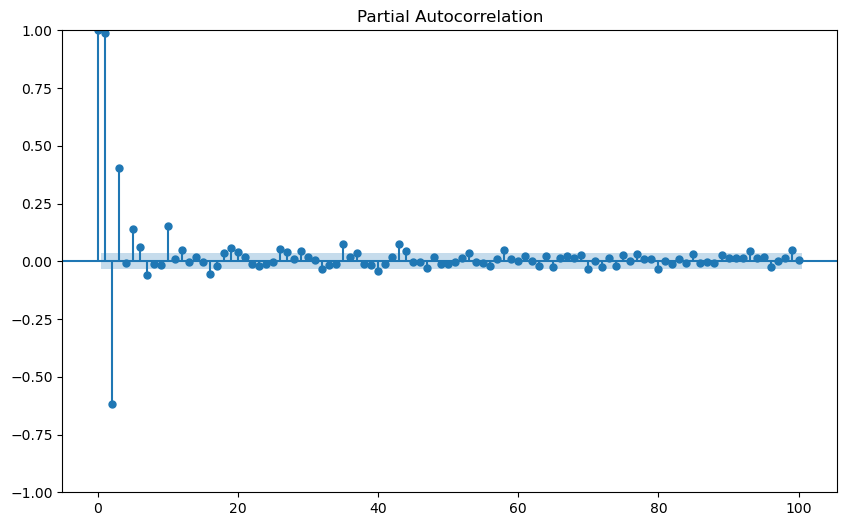

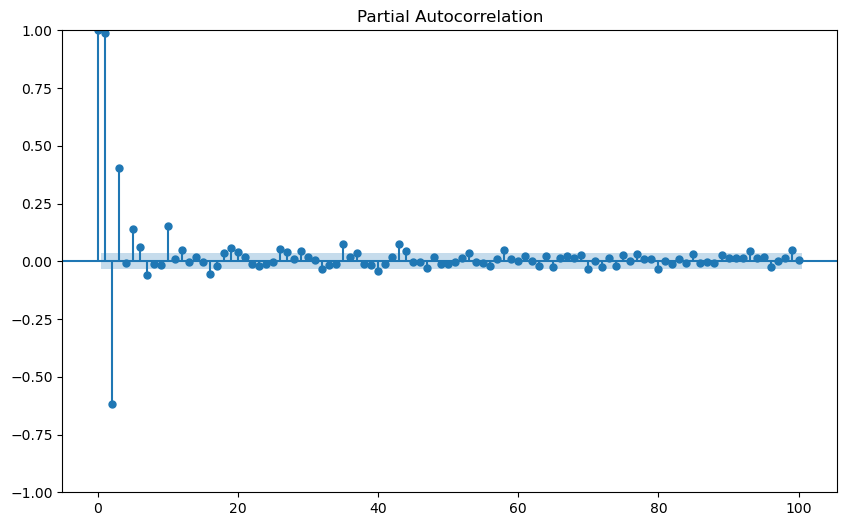

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

discharge_series = df_esm_3h['hidro_level_sm']
discharge_series.dropna(inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(discharge_series, ax=ax, lags=100, method='ywm')  

Merge the ccs data and Esmeradals data from CAE together and output to the local .csv file

In [36]:
import numpy as np
from statsmodels.tsa.stattools import pacf
import plotly.graph_objects as go

# Generate sample data
np.random.seed(42)
data = np.random.randn(100)

# Calculate PACF values
pacf_values, confidence_interval = pacf(discharge_series, nlags=100, alpha=0.05)

# Create the PACF plot
fig = go.Figure()

# Add PACF values as vertical lines with dots on top
for i, value in enumerate(pacf_values):
    fig.add_shape(type="line",
                  x0=i, y0=0, x1=i, y1=value,
                  line=dict(color="blue", width=1))
    fig.add_trace(go.Scatter(x=[i], y=[value], mode='markers', marker=dict(color='blue', size=6)))

# Add confidence interval lines
fig.add_shape(type="line",
              x0=0, y0=confidence_interval[0, 0], x1=len(pacf_values), y1=confidence_interval[0, 0],
              line=dict(color="grey", width=1, dash="dash"))
fig.add_shape(type="line",
              x0=0, y0=confidence_interval[1, 0], x1=len(pacf_values), y1=confidence_interval[1, 0],
              line=dict(color="grey", width=1, dash="dash"))

# Customize the layout
fig.update_layout(title="Partial Autocorrelation Function (PACF)",
                  xaxis_title="Lag",
                  yaxis_title="PACF",
                  showlegend=False,
                  yaxis=dict(range=[-1, 1]))

# Display the plot
fig.show()

In [8]:
merged_df = pd.merge(df_ccs, df_esm_3h, left_index=True, right_index=True, how='outer')
merged_df.shape
# shape of (time, 2759), where 2759 = 53*52 (# of pixels de Esm basin ) + 3 (# of sensors)
start = str(merged_df.index[0].date())
end  = str(merged_df.index[-1].date())
merged_df.to_csv(f'merged_{start}_{end}.csv', compression= None)